# Sentiment Model with TensorFlow and Transformers

## Getting the Data

In [2]:
# !pip install kaggle
# !pip install transformers

In [3]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"artemkel","key":"538e49db7e08967bd16401549e0fef8f"}'}

In [4]:
# put kaggle.json in the required directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
import pandas as pd
import numpy as np
from transformers import BertTokenizer
import tensorflow as tf

In [6]:
api = KaggleApi()
api.authenticate()

In [7]:
api.competition_download_file('sentiment-analysis-on-movie-reviews',
                              'test.tsv.zip', path='./')
api.competition_download_file('sentiment-analysis-on-movie-reviews',
                              'train.tsv.zip', path='./')

100%|██████████| 494k/494k [00:00<00:00, 10.3MB/s]

100%|██████████| 1.28M/1.28M [00:00<00:00, 16.6MB/s]

In [8]:
with zipfile.ZipFile('./test.tsv.zip') as zipref:
    zipref.extractall('./')

with zipfile.ZipFile('./train.tsv.zip') as zipref:
    zipref.extractall('./')

## Data Preprocessing

In [9]:
df = pd.read_csv('train.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [10]:
# df.drop_duplicates(subset=['SentenceId'], keep='first')

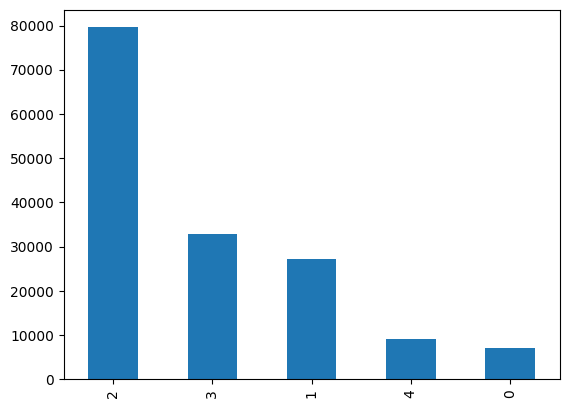

In [11]:
df['Sentiment'].value_counts().plot(kind='bar');

In [12]:
seq_len = 512
num_samples = len(df)

num_samples, seq_len

(156060, 512)

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [14]:
tokens = tokenizer(df['Phrase'].tolist(), max_length=seq_len,
                   truncation=True, padding='max_length',
                   add_special_tokens=True,
                   return_tensors='np')

In [15]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [16]:
tokens['input_ids']

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]])

In [17]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [18]:
with open('movie-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])

with open('movie-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [19]:
arr = df.Sentiment.values

In [20]:
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(156060, 5)

In [21]:
labels[np.arange(num_samples), arr] = 1

In [22]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [23]:
with open('movie-labels.npy', 'wb') as f:
    np.save(f, labels)

## Set up Input Pipeline

In [24]:
with open('movie-xids.npy', 'rb') as f:
    Xids = np.load(f, allow_pickle=True)
with open('movie-xmask.npy', 'rb') as f:
    Xmask = np.load(f, allow_pickle=True)
with open('movie-labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

In [25]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [26]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [27]:
def map_function(input_ids, masks, labels):
  return {'input_ids': input_ids,
          'attention_mask': masks}, labels

In [28]:
dataset = dataset.map(map_function)

In [29]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int64, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [30]:
# test